# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В моем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install phik
!pip install -U scikit-learn

     |████████████████████████████████| 686 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 76.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse
from statistics import mode
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import phik

In [3]:
def pie_diag(df, i):
    plt.figure
    df1 = df.groupby(i)[i].count().sort_values(ascending=False)
    labels = df1.index
    n = len(labels)
    colors = sns.color_palette('pastel')[0:n]
    plt.pie(df1, labels=labels, colors = colors, autopct='%1.1f%%')
    
def graf(df, i):
    plt.rcParams['figure.figsize'] = [15, 4]
    sns.set(style='whitegrid')
    plt.subplot(1, 2, 1)
    sns.histplot(data = df, x = df[i], kde=True, bins=10)
    plt.subplot(1, 2, 2)
    sns.boxplot(data = df, x = df[i], palette='pastel')

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка данных

### Загрузка и проверка типов данных

In [5]:
df = pd.read_csv('/datasets/autos.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [7]:
df['LastSeen'].sort_values(ascending=False)[0] #дата последней активности

Timestamp('2016-04-07 03:16:57')

Данные загружены корректно. Названия столбцов написаны в верблюжьем стиле, менять не буду. Есть признаки, которые требуют детального рассмотрения. 

### Поиск и удаление дубликатов

In [8]:
object_columns = df.select_dtypes(include=['object']).columns.to_list()
object_columns #если есть неявные дубликаты, то их можно будет найти в столбцах со строковым типом данных

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [9]:
object_columns.remove('Model') #даже если будет ошибка в написании, это понять будет нельзя, так как это могут быть два
                               #похожих названия моделей разных марок машин
for i in object_columns:
    print(i)
    print(df[i].unique())
    print()

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Gearbox
['manual' 'auto' nan]

FuelType
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

Brand
['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']

Repaired
[nan 'yes' 'no']



Повторов с ошибками в столбцах со строковым типом данных нет.

Неявных дубликатов тоже нет.

In [10]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

Удалил явные дубликаты.

### Анализ пропущенных значений

In [11]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропусков много, самое важное &mdash; понять, как заполнить модель машины. Создам копию датасета, удалю из него все пропуски и посмотрю корреляцию признаков с таргетом, может быть, некоторые признаки никак не влияют на цену и их можно удалить.

In [12]:
#очевидно, что представленые даты не влияют на цену, как и индекс
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1)

Сначала заполню пропуски в столбце с названиями моделей. Пропущенные значения буду заполнять модой по типу кузова этой марки автомобиля.

In [13]:
brands = df['Brand'].unique()
vehicle_types = df['VehicleType'].unique()

for i in brands:
    for j in vehicle_types:
        if not df[(df['Brand'] == i) & (df['VehicleType'] == j)& (df['Model'].isna() == False)].empty:
            mode_value = mode(df[(df['Brand'] == i) & (df['VehicleType'] == j) & (df['Model'].isna() == False)]['Model'])
            df.loc[(df['Brand'] == i) & (df['VehicleType'] == j), 'Model'] = (
                df[(df['Brand'] == i) & (df['VehicleType'] == j)]['Model'].fillna(mode_value))

In [14]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                 9163
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
NumberOfPictures         0
dtype: int64

Получилось заполнить больше половины пропусков. Оставшиеся пропуски заполню просто модой по марке.

In [15]:
for i in brands:
    if not df[(df['Brand'] == i) & (df['Model'].isna() == False)].empty:
        mode_value = mode(df[(df['Brand'] == i) & (df['Model'].isna() == False)]['Model'])
        df.loc[df['Brand'] == i, 'Model'] = df[df['Brand'] == i]['Model'].fillna(mode_value)

In [16]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                 3374
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
NumberOfPictures         0
dtype: int64

Все равно остались пропуски, надо посмотреть на марки автомобилей.

In [17]:
display(df[df['Model'].isna()]['Brand'].unique())
df[df['Model'].isna()].head()

array(['sonstige_autos'], dtype=object)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,0
306,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,0
431,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,0
650,15000,coupe,1971,NaN,0,NaN,5000,4,NaN,sonstige_autos,no,0
661,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no,0


In [18]:
df[df['Brand'] == 'sonstige_autos'].isna().sum()

Price                   0
VehicleType          1041
RegistrationYear        0
Gearbox              1103
Power                   0
Model                3374
Kilometer               0
RegistrationMonth       0
FuelType             1104
Brand                   0
Repaired             1323
NumberOfPictures        0
dtype: int64

Автомобили марки 'sonstige_autos' не имеют деления на модели. Их можно было бы разделить на модели по типу кузова, но примерно у трети тип кузова отсутствует. Автомобили этой марки составляют примерно 1% от всего датасета, думаю, что их удаление не повлияет на анализ.

In [19]:
df = df.drop(df[df['Brand'] == 'sonstige_autos'].index)

Далее займусь заполнением всех остальных пропусков.

In [20]:
models = df['Model'].unique()
for i in models:
    mode_value = mode(df[(df['Model'] == i) & (df['VehicleType'].isna() == False)]['VehicleType'])
    df.loc[df['Model'] == i, 'VehicleType'] = df[df['Model'] == i]['VehicleType'].fillna(mode_value)
    mode_value = mode(df[(df['Model'] == i) & (df['Gearbox'].isna() == False)]['Gearbox'])
    df.loc[df['Model'] == i, 'Gearbox'] = df[df['Model'] == i]['Gearbox'].fillna(mode_value)
    mode_value = mode(df[(df['Model'] == i) & (df['FuelType'].isna() == False)]['FuelType'])
    df.loc[df['Model'] == i, 'FuelType'] = df[df['Model'] == i]['FuelType'].fillna(mode_value)

In [21]:
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             69831
NumberOfPictures         0
dtype: int64

Заполнил все пропуски, кроме информации о ремонте. Её заполню случайным образом нулями и единицами.

In [22]:
df[df['Power'] == 0]['Repaired'].value_counts()

no     13712
yes     4714
Name: Repaired, dtype: int64

In [23]:
df['Repaired'] = df['Repaired'].fillna(np.random.choice(['no', 'yes']))
df['Repaired'] = df['Repaired'].replace(['no', 'yes'], [0, 1])

df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
NumberOfPictures     0
dtype: int64

Пропуски заполнил.

In [24]:
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol')

In [25]:
df['NumberOfPictures'].unique()

array([0])

In [26]:
df = df.drop(columns=['NumberOfPictures', 'RegistrationMonth']) #эти признаки не влияют на цену
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,1
1,18300,coupe,2011,manual,190,tt,125000,petrol,audi,1
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,1
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,0
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,0
354364,0,small,2005,manual,0,colt,150000,petrol,mitsubishi,1
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,0
354367,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,0


### Исследовательский анализ

In [27]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,1
1,18300,coupe,2011,manual,190,tt,125000,petrol,audi,1
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,1
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,0


In [28]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,Repaired
count,350991.000000,350991.000000,350991.000000,350991.000000,350991.000000
mean,4410.822004,2004.067070,110.267061,128574.507608,0.300999
std,4503.363915,79.123471,189.081382,37470.166343,0.458693
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1099.000000,1999.000000,69.000000,125000.000000,0.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,0.000000
75%,6399.000000,2008.000000,142.000000,150000.000000,1.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,1.000000


Вижу, что цена некоторых машин равна нулю, как и мощность. Это ошибки, которые нужно обработать.

Также есть ошибки в столбце с годом регистрации.

In [29]:
df = df[(df['RegistrationYear'] >= 1980) & (df['RegistrationYear'] < 2017)] #последняя активность была в 2016 

In [30]:
df[df['Price'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,0
40,0,small,1990,manual,0,corsa,150000,petrol,opel,1
115,0,small,1999,manual,0,polo,5000,petrol,volkswagen,1
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,1
154,0,sedan,2006,manual,0,other,5000,petrol,fiat,1
...,...,...,...,...,...,...,...,...,...,...
354205,0,small,2000,manual,65,corsa,150000,petrol,opel,1
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,1
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,1
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,1


Количество строк с ценой, равной 0, составляет 3%. Удалю эти значения.

In [31]:
df = df[df['Price'] > 0]

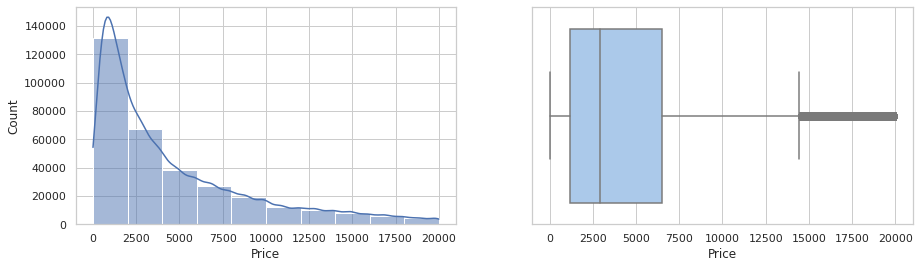

In [32]:
graf(df, 'Price')

In [33]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,Repaired
count,324508.000000,324508.000000,324508.000000,324508.000000,324508.000000
mean,4574.007575,2002.928177,112.222118,128809.644138,0.279962
std,4521.625414,6.005811,182.412988,36885.652460,0.448981
min,1.000000,1980.000000,0.000000,5000.000000,0.000000
25%,1200.000000,1999.000000,72.000000,125000.000000,0.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,0.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,1.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,1.000000


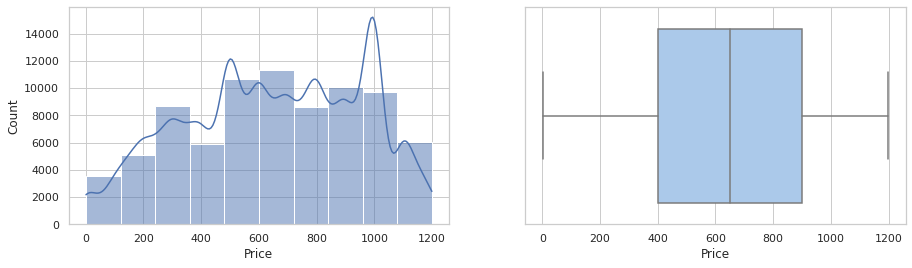

In [34]:
graf(df[df['Price'] < 1200], 'Price') #посмотрю на данные по 25% квартилю

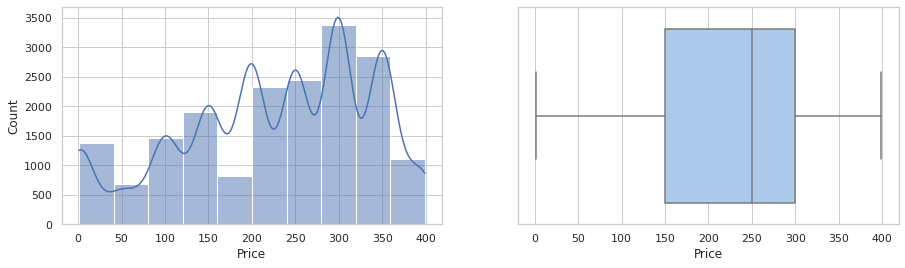

In [35]:
graf(df[df['Price'] < 400], 'Price') #настораживает большое количество авто с ценой до 50 евро

In [36]:
df[df['Price'] < 50]['Price'].value_counts()

1     1000
10      74
30      47
40      43
20      39
25      26
5       23
15      22
35      18
45      13
49      11
2        9
8        9
9        8
12       6
13       6
3        6
39       6
17       5
14       4
7        3
11       3
29       2
18       2
16       2
26       1
27       1
4        1
32       1
33       1
21       1
38       1
47       1
24       1
Name: Price, dtype: int64

Из общей массы выделяются значения с ценой равной 1 доллару. Считаю такие строки аномалией, удалю их.

In [37]:
df = df[df['Price'] > 1]

In [38]:
df[df['Power'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,1
32,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,0
37,1500,bus,2016,manual,0,kangoo,150000,petrol,renault,0
54,4700,wagon,2005,manual,0,signum,150000,petrol,opel,0
55,550,wagon,1999,manual,0,astra,150000,petrol,opel,1
...,...,...,...,...,...,...,...,...,...,...
354335,390,small,1997,auto,0,corsa,100000,petrol,opel,1
354336,3299,suv,2005,auto,0,outlander,150000,petrol,mitsubishi,1
354338,180,small,1995,manual,0,corsa,125000,petrol,opel,1
354346,2600,sedan,2005,auto,0,c_klasse,150000,petrol,mercedes_benz,1


10% строк с аномалией, надо изменить значения на моду по модели.

In [39]:
df[df['Power'] == 0]['Repaired'].value_counts()

1    19406
0    11534
Name: Repaired, dtype: int64

In [40]:
for i in models:
    if not df[(df['Model'] == i) & (df['Power'] > 0)].empty:
        mode_value = mode(df[(df['Model'] == i) & (df['Power'] > 0)]['Power'])
        df.loc[(df['Model'] == i) & (df['Power'] == 0) & (df['Repaired'] == 0), 'Power'] = mode_value

In [41]:
df[df['Power'] == 0]['Repaired'].count() == df[df['Power'] == 0]['Repaired'].sum()

True

In [42]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,1
1,18300,coupe,2011,manual,190,tt,125000,petrol,audi,1
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,1
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,0


In [43]:
num_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

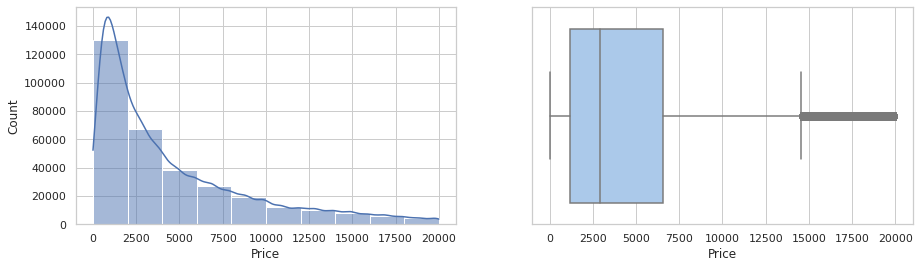

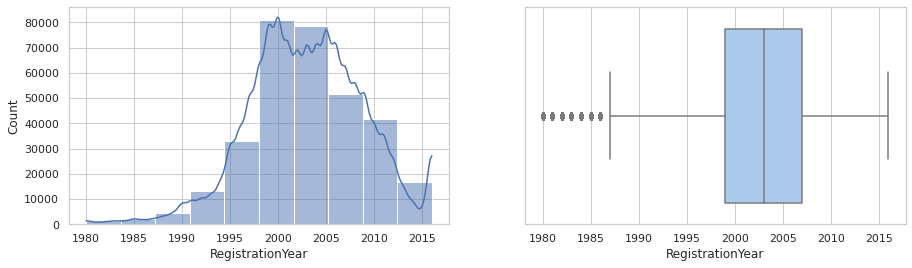

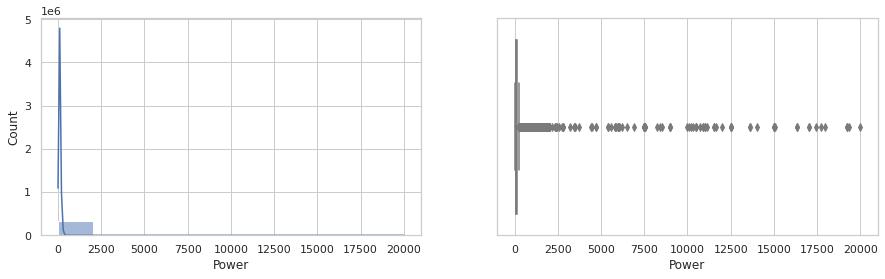

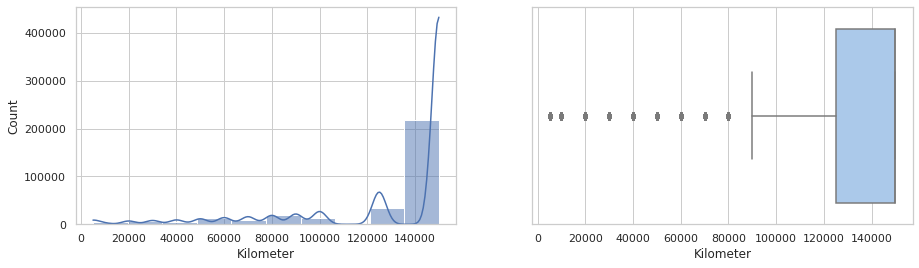

In [44]:
for i in num_columns:
    graf(df, i)
    plt.show()

In [45]:
df[df['Power'] > 700] #в датасете представлены авто среднего сегмента, поэтому предполагаю макс. мощность равной 700

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,0
4060,3100,sedan,2005,manual,953,colt,150000,petrol,mitsubishi,0
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,1
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,1
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,1
...,...,...,...,...,...,...,...,...,...,...
348668,1000,wagon,1996,manual,2598,a6,150000,petrol,audi,1
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,1
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,1
351947,1500,bus,2001,manual,1001,zafira,5000,petrol,opel,0


Удалю представленные машины.

In [46]:
df = df[df['Power'] < 700]

<AxesSubplot:>

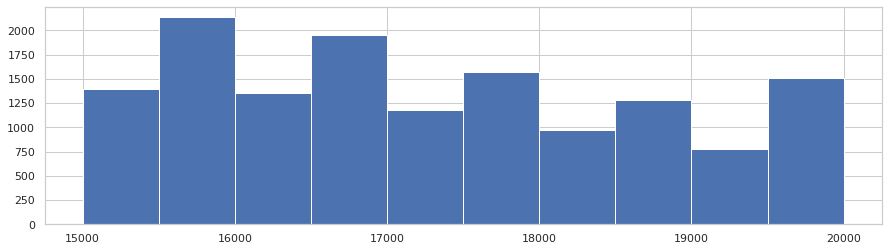

In [47]:
df[df['Price'] > 15000]['Price'].hist()

Распределение данных выше границы верхнего уса по цене равномерно с убыванием. Считаю, что эти данные не имеют аномальный характер.

Остальные данные оставлю, может быть, графики отображают тенденции, которые пока не очевидны.

### Корреляционный анализ

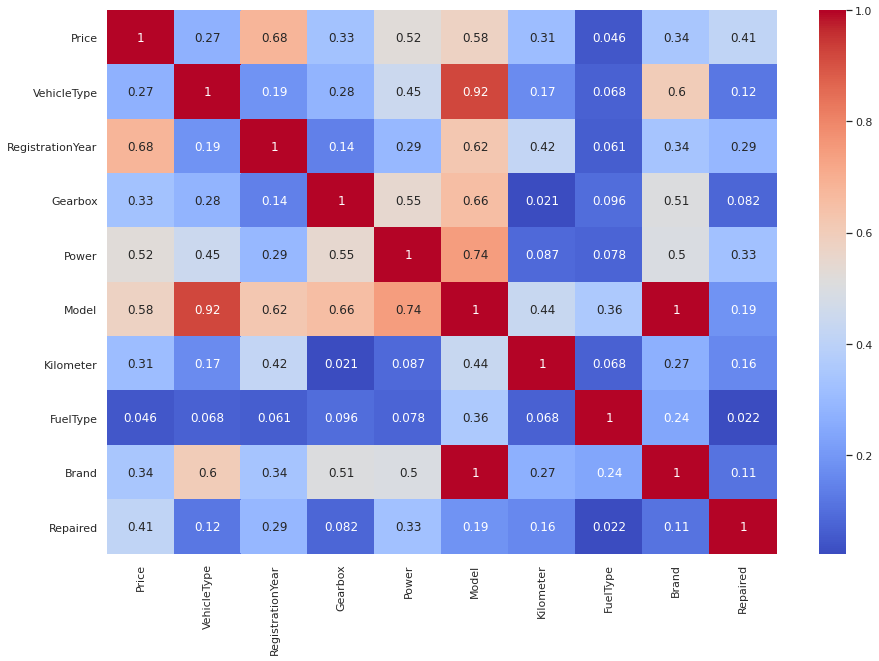

In [48]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.phik_matrix(interval_cols=num_columns), annot=True, cmap='coolwarm')
plt.show()

Есть подозрение на мультиколлинеарность. После кодирования проверю VIF-ом.

## Обучение моделей

In [49]:
df = df.reset_index(drop=True)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,1
1,18300,coupe,2011,manual,190,tt,125000,petrol,audi,1
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,1
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,0


In [50]:
num_columns.remove('Price')
ohe_columns = ['Gearbox', 'Repaired']
ord_columns = ['Model', 'FuelType', 'Brand', 'VehicleType']

In [51]:
X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [53]:
ohe_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)

X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_valid_ohe = ohe_encoder.transform(X_valid[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
encoder_ohe_names = ohe_encoder.get_feature_names_out()

df_ohe_train = pd.DataFrame(X_train_ohe, columns=encoder_ohe_names)
df_ohe_valid = pd.DataFrame(X_valid_ohe, columns=encoder_ohe_names)
df_ohe_test = pd.DataFrame(X_test_ohe, columns=encoder_ohe_names)

In [54]:
X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
X_valid_ord = ord_encoder.transform(X_valid[ord_columns])
X_test_ord = ord_encoder.transform(X_test[ord_columns])
encoder_ord_names = ord_encoder.get_feature_names_out()

df_ord_train = pd.DataFrame(X_train_ord, columns=encoder_ord_names)
df_ord_valid = pd.DataFrame(X_valid_ord, columns=encoder_ord_names)
df_ord_test = pd.DataFrame(X_test_ord, columns=encoder_ord_names)

In [55]:
scaler = MinMaxScaler()
scaler.fit(X_train[num_columns])
X_train_scaled = scaler.transform(X_train[num_columns])
X_valid_scaled = scaler.transform(X_valid[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

df_scaled_train = pd.DataFrame(X_train_scaled, columns=num_columns)
df_scaled_valid = pd.DataFrame(X_valid_scaled, columns=num_columns)
df_scaled_test = pd.DataFrame(X_test_scaled, columns=num_columns)

In [56]:
X_train = pd.concat([df_scaled_train, df_ohe_train, df_ord_train], axis=1)
X_valid = pd.concat([df_scaled_valid, df_ohe_valid, df_ord_valid], axis=1)
X_test = pd.concat([df_scaled_test, df_ohe_test, df_ord_test], axis=1)

Сейчас можно проверить признаки 'Model', 'VehicleType', 'Brand' на мультиколлинеарность.

In [57]:
df_ = X_train[['Model', 'Brand', 'VehicleType']]

vif_df = pd.DataFrame() 
vif_df['feature'] = df_.columns

vif_df['VIF'] = [variance_inflation_factor(df_.values, i) 
                          for i in range(len(df_.columns))]
vif_df

,feature,VIF
0,Model,3.706813
1,Brand,4.059232
2,VehicleType,2.422552


Значения ниже 5, значит, мультиколлинеарности не обнаружено.

### DecisionTreeRegressor

In [58]:
%%time

warnings.filterwarnings('ignore')

model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

max_depth = range(1, 20)
min_samples_split = range(1, 10)
min_samples_leaf = range(1, 10)

param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

randomized_search_dtr = RandomizedSearchCV(
    model_dtr,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_dtr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_dtr.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_dtr.best_score_)

Лучшая модель и её параметры:

 DecisionTreeRegressor(max_depth=16, min_samples_leaf=9, min_samples_split=8,
                      random_state=42)
Метрика лучшей модели на тренировочной выборке: -1802.4457274293534
CPU times: user 13.7 s, sys: 35.4 ms, total: 13.7 s
Wall time: 13.8 s


### LGBMRegressor

Ниже в анализе рассмотрю дефолтную модель LGMBRegressor.

In [59]:
%%time

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

num_leaves = range(1, 100, 4)
max_depth = range(1, 20)
n_estimators = range(1, 100, 4)

param_grid = dict(num_leaves=num_leaves, max_depth=max_depth, n_estimators=n_estimators)

randomized_search_lgbm = RandomizedSearchCV(
    model_lgbm,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_lgbm.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_lgbm.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_lgbm.best_score_)

Лучшая модель и её параметры:

 LGBMRegressor(max_depth=12, n_estimators=61, num_leaves=81, random_state=42)
Метрика лучшей модели на тренировочной выборке: -1664.5620159337413
CPU times: user 1min 57s, sys: 458 ms, total: 1min 57s
Wall time: 1min 59s


## Анализ моделей

### Модель DecisionTreeRegressor

In [60]:
%%time

model_dtr = randomized_search_dtr.best_estimator_
model_dtr.fit(X_train, y_train)

CPU times: user 469 ms, sys: 0 ns, total: 469 ms
Wall time: 504 ms


DecisionTreeRegressor(max_depth=16, min_samples_leaf=9, min_samples_split=8,
                      random_state=42)

In [61]:
%%time

dtr_pred = model_dtr.predict(X_valid)

CPU times: user 18 ms, sys: 0 ns, total: 18 ms
Wall time: 16.4 ms


In [62]:
RMSE = (mse(y_valid, dtr_pred))**0.5
RMSE

1782.3402215045087

### Модель LGBMRegressor (1)

In [63]:
%%time

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE) #сначала построю модель без изменения гиперпараметров, должно
model_lgbm.fit(X_train, y_train)                      #быть быстрее

CPU times: user 4.93 s, sys: 24.1 ms, total: 4.96 s
Wall time: 5.04 s


LGBMRegressor(random_state=42)

In [64]:
%%time

lgbm_pred = model_lgbm.predict(X_valid)

CPU times: user 463 ms, sys: 12 ms, total: 475 ms
Wall time: 497 ms


In [65]:
RMSE = (mse(y_valid, lgbm_pred))**0.5
RMSE

1689.8622726752255

### Модель LGBMRegressor (2)

In [66]:
%%time

model_lgbm_rc = randomized_search_lgbm.best_estimator_
model_lgbm_rc.fit(X_train, y_train)

CPU times: user 5.7 s, sys: 37 ms, total: 5.74 s
Wall time: 5.89 s


LGBMRegressor(max_depth=12, n_estimators=61, num_leaves=81, random_state=42)

In [67]:
%%time

lgbm_rc_pred = model_lgbm_rc.predict(X_valid)

CPU times: user 388 ms, sys: 0 ns, total: 388 ms
Wall time: 397 ms


In [68]:
RMSE = (mse(y_valid, lgbm_rc_pred))**0.5
RMSE

1664.495439089687

## Вывод

Лучшей моделью считаю LGBMRegressor с измененными гиперпараметрами, качество этой модели лучше, чем у всех остальных, в скорости проигрывает DecisionTreeRegressor, но разница в 4-5 секундах, не думаю, что это существенно.

In [69]:
lgbm_rc_pred = model_lgbm_rc.predict(X_test)
RMSE = (mse(y_test, lgbm_rc_pred))**0.5
RMSE

1656.8340201323651